In [1]:
using ONNXNaiveNASflux
using Random
using Flux, Statistics, ProgressMeter, Plots, TaijaData, Distances, MLDatasets, CSV, DataFrames
using Flux: onehotbatch, onecold, crossentropy, logitcrossentropy, mse, throttle, update!, push!

### Loading up our saved models

In [2]:
adv_pgd_strong = ONNXNaiveNASflux.load("../models/adv_pgd_strong.onnx")
adv_pgd_medium = ONNXNaiveNASflux.load("../models/adv_pgd_medium.onnx")
adv_pgd_weak = ONNXNaiveNASflux.load("../models/adv_pgd_weak.onnx")
model = ONNXNaiveNASflux.load("../models/classically_trained.onnx")

CompGraph with graphsummary:
┌────────────────┬───────────┬────────────────┬─────────────────────────┐
│ Graph Position │ Vertex Nr │ Input Vertices │ Op                      │
├────────────────┼───────────┼────────────────┼─────────────────────────┤
│ Input          │ 1         │                │                         │
│ Hidden         │ 2         │ 1              │ Dense(784 => 128, relu) │
│ Output         │ 3         │ 2              │ Dense(128 => 10)        │
└────────────────┴───────────┴────────────────┴─────────────────────────┘


### Loading up our MNIST data

In [3]:
train_df = CSV.read("../data/mnist_train.csv", DataFrame; header=false)
train_data = Matrix(train_df)

test_df = CSV.read("../data/mnist_test.csv", DataFrame; header=false)
test_data = Matrix(test_df)

x_train = train_data[:, 2:785]' ./ 255
y_train = train_data[:, 1]

x_test = test_data[:, 2:785]' ./ 255
y_test = test_data[:, 1]

x_train

784×60000 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱            ⋮                   
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 

### Preparing models for Counterfactual generation

In [4]:
using CounterfactualExplanations

flux_clean = CounterfactualExplanations.MLP(model; likelihood=:classification_multi)
flux_adv_strong = CounterfactualExplanations.MLP(adv_pgd_strong; likelihood=:classification_multi)
flux_adv_medium = CounterfactualExplanations.MLP(adv_pgd_medium; likelihood=:classification_multi) 
flux_adv_weak = CounterfactualExplanations.MLP(adv_pgd_weak; likelihood=:classification_multi)

CounterfactualExplanations.Models.Model(CompGraph(3 vertices), :classification_multi, CounterfactualExplanations.Models.Fitresult(CompGraph(3 vertices), Dict{Any, Any}()), MLP())

### Plot random counterfactuals

In [5]:
counterfactual_data = CounterfactualData(x_train, y_train)
counterfactual_data.domain = [(0, 1) for var in counterfactual_data.features_continuous]
generator = CounterfactualExplanations.ECCoGenerator(; λ=[0.01, 0.1])
convergence = CounterfactualExplanations.GeneratorConditionsConvergence(decision_threshold=0.7, max_iter=1000)

CounterfactualExplanations.Convergence.GeneratorConditionsConvergence(0.7, 0.01, 1000, 0.75)

CounterfactualExplanation
Convergence: ❌ after 1000 steps.
image = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00013379228525991493, 0.0, 0.0, 3.726289778569481e-5, 6.897724556438334e-5, 0.0, 0.00017839170891420508, 0.0, 0.0, 5.974771329420037e-6, 1.6211687762890392e-5, 9.604505589777546e-5, 0.0, 0.0, 0.0, 0.0, 0.0, 4.093175166417496e-5, 0.0, 0.0, 0.0, 1.7359070147904278e-5, 1.1566353941816488e-5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0001283669007534627, 0.00041157771047437567, 0.0004503499243583065, 4.951389075722541e-5, 8.905387789127331e-6, 0.0, 0.0, 0.00037903353386354867, 0.2169728426632303, 0.0004971833228628384, 0.24171676532723924, 0.1120997419519171, 0.0, 0.00017283297966059764, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.3347041422994153e-5, 0.0, 0.0, 0.0, 0.0004036892252770486, 0.000268500159290852, 2.1133781978278357e-5, 0.0004886716029432137, 1.0, 0.07392710902532319, 0.08598517097017364, 0.14402009789882939, 0.000545416644308716, 0.4634418198949952, 0.00035316068335669115, 0.0, 0.000397282

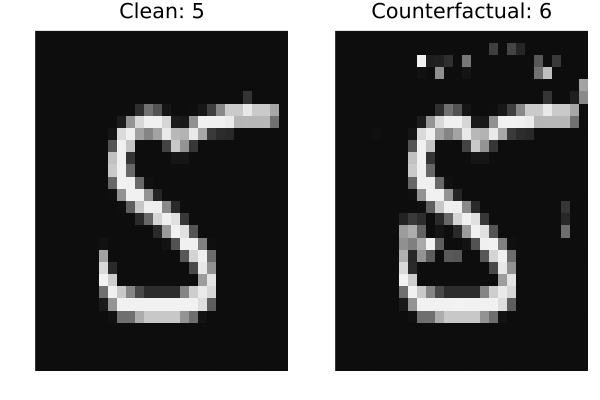

In [31]:
include("../utils/plot.jl")

using CounterfactualExplanations.Evaluation: evaluate, validity

model_to_use = flux_clean
# model_to_use = flux_adv_strong
# model_to_use = flux_adv_medium
# model_to_use = flux_adv_weak

# random point's Counterfactual
index = rand(1:10000)

different_label = rand(0:8)
if different_label >= y_test[index]
    different_label += 1
end
 
ce = generate_counterfactual(
        reshape(x_test[:, index], 784, 1), different_label, counterfactual_data, model_to_use, generator; num_counterfactuals=1, convergence=convergence
    )

println(ce)

ces = CounterfactualExplanations.counterfactual(ce)
cfimage = ces[:, 1]
println("image = ", cfimage)
println("correct_class = ", ce.target)

inf_model = model
# inf_model = adv_pgd_strong
# inf_model = adv_pgd_medium
# inf_model = adv_pgd_weak

cf_pred = (inf_model(cfimage) |> Flux.onecold |> getindex) - 1
println("valid? ", evaluate(ce; measure=validity)[1][1])
actualimage = x_test[:, index]
actual_pred = (inf_model(actualimage) |> Flux.onecold |> getindex) - 1
plot_normal_and_ce(actualimage, actual_pred, cfimage, cf_pred, y_test[index])

### Experimental Setup

In [10]:
Random.seed!(42)

function generate_split(num_datapoints)
    rand(1:num_datapoints, 200)
end

function random_excluding(exclude)
    value = rand(0:8)
    return value < exclude ? value : value + 1
end

split = generate_split(length(y_test))
targets = [random_excluding(y_test[num]) for num in split]

extrema(abs.(y_test[split] - targets))

# splits = [generate_split(length(y_test)) for _ in 1:5]
# targets = [[random_excluding(y_test[num]) for num in split] for split in splits]

(1, 9)

#### Experiment: Clean Model

In [16]:
using CounterfactualExplanations

model_to_use = model
counterfactuals = []

for (j, index) in enumerate(split)
    
    model_pred = (model_to_use(x_test[:, index]) |> Flux.onecold |> getindex) - 1
    if model_pred != y_test[index]
        println("skipping since the model misclassified this point")
        continue
    end

    if (j % 10 == 0)
        println("reached datapoint ", j)
    end

    ce = generate_counterfactual(
        reshape(x_test'[index, :], 784, 1), targets[j], counterfactual_data, flux_clean, generator; num_counterfactuals=1, convergence=convergence
    )

    ce_datapoint = CounterfactualExplanations.counterfactual(ce)[:, 1]

    # print("counterfactual instance: ", ce_datapoint)
    push!(counterfactuals, ce_datapoint)
end

counterfactuals

reached datapoint 10
skipping since the model misclassified this point
reached datapoint 20
reached datapoint 30
reached datapoint 40
reached datapoint 50
reached datapoint 60
reached datapoint 70
reached datapoint 80
skipping since the model misclassified this point
reached datapoint 90
reached datapoint 100
reached datapoint 110
reached datapoint 120
reached datapoint 130
reached datapoint 140
skipping since the model misclassified this point
reached datapoint 150
skipping since the model misclassified this point
reached datapoint 160
reached datapoint 170
reached datapoint 180
reached datapoint 190
reached datapoint 200


196-element Vector{Any}:
 [0.0, 0.0, 0.0, 5.721559555240674e-5, 0.0, 0.0, 0.0, 0.0, 2.807814034895273e-5, 0.0  …  0.0, 0.00011314076036796906, 0.0, 0.7576629602165036, 0.6224222004870014, 0.5699432776557247, 0.0, 0.0, 0.0, 1.186668805530644e-5]
 [0.00010970564110266424, 0.0, 0.0, 0.0, 5.2836496320196605e-5, 2.510251177909595e-5, 0.0, 2.1221211898136972e-5, 0.0, 0.0  …  9.111349113481993e-5, 0.00025828050584095766, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.720748160276344e-5, 0.0]
 [0.0, 0.0, 0.0, 1.9298038523629656e-6, 0.0, 0.0, 0.0, 0.0, 0.00013362909812713044, 0.0  …  0.0005211834770307178, 0.0, 0.0, 0.0627648073772501, 0.0004899332077911823, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 6.927654600303867e-5, 0.0, 0.0, 7.459832795575494e-6, 0.0, 6.348716965476342e-5, 1.412385436196928e-5  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.00010672951198102965, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 3.2303082576845554e-5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.333103457905054e-5  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.707231355747354e-5

In [18]:
using DataFrames
using CSV

df = DataFrame(mapreduce(permutedims, vcat, counterfactuals), :auto)
CSV.write("data.csv", df)

df

Row,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61,x62,x63,x64,x65,x66,x67,x68,x69,x70,x71,x72,x73,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83,x84,x85,x86,x87,x88,x89,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99,x100,⋯
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,⋯
1,0.0,0.0,0.0,5.72156e-5,0.0,0.0,0.0,0.0,2.80781e-5,0.0,1.20981e-5,0.0,0.0,0.0,0.0,0.0,0.0,0.000109168,0.0,0.0,0.0,3.8204e-6,0.0,0.0,0.0,4.68836e-5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.14336e-5,0.0,0.000278736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000180597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000365774,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,⋯
2,0.000109706,0.0,0.0,0.0,5.28365e-5,2.51025e-5,0.0,2.12212e-5,0.0,0.0,0.0,0.0,1.91655e-5,0.0,0.0,0.0,0.0,7.86196e-6,0.0,3.57292e-5,0.0,0.0,6.36495e-5,0.0,7.6353e-5,0.0,0.0,0.0,0.0,7.51777e-5,0.0,8.5577e-5,0.0,0.0,0.000142542,0.0,0.0,1.48106e-5,0.0,0.0,0.0,0.000282526,0.000538518,0.0,0.0,0.0,0.0,0.0,0.000608944,0.0,0.0,0.0,7.29334e-5,0.0,0.0,2.52496e-5,0.0,7.2174e-5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000736315,0.293463,0.0,0.000345086,0.0,0.00034968,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000610932,0.000379938,0.107648,0.0,0.0,0.0,0.0,0.0,⋯
3,0.0,0.0,0.0,1.9298e-6,0.0,0.0,0.0,0.0,0.000133629,0.0,0.0,0.0,0.0,0.0,0.0,0.000155453,0.0,0.0,5.75533e-5,0.0,0.000102875,0.0,0.0,0.0,0.0,0.0,2.8656e-6,0.000103737,0.0,0.0,0.0,0.0,0.0,1.33231e-5,0.0,0.0,3.61017e-5,0.0,0.0,0.0,0.00024028,0.0,0.0,0.0,0.0,0.000119746,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000124556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.03868e-5,0.000359923,0.000271827,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000155049,0.0,0.0,0.0,0.0,0.0,0.0,⋯
4,0.0,0.0,0.0,6.92765e-5,0.0,0.0,7.45983e-6,0.0,6.34872e-5,1.41239e-5,0.0,0.0,3.91958e-5,4.71376e-5,3.51594e-6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.77062e-5,5.63922e-5,0.0,0.0,0.0,8.26942e-5,0.0,6.60014e-6,0.0,0.0,7.62648e-5,0.0,0.0,0.000117111,4.66814e-5,0.0,5.56391e-5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000278395,0.000215868,0.0,0.000189572,0.000181765,2.86825e-5,0.0,3.60792e-5,0.0,0.0,3.29483e-6,0.0,0.0,4.69416e-5,0.0,0.0,0.000213193,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.91086e-5,0.000376932,0.0,0.0,0.000253112,0.000474949,0.0,0.00016262,4.29676e-5,0.0,0.0,0.00013724,0.0,0.0,0.0,0.0975095,0.000445644,0.27505,0.000847982,0.294246,0.00045542,0.0,0.000157549,0.0,0.0,0.0,0.0,⋯
5,0.0,0.0,3.23031e-5,0.0,0.0,0.0,0.0,0.0,0.0,6.3331e-5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.67108e-6,0.0,0.0,0.0,0.0,0.0,0.0,9.55044e-5,0.0,2.77973e-5,0.0,0.0,0.0,0.0,0.0,2.64128e-6,0.0,0.0,0.0,0.0,8.2454e-5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.08406e-6,0.0,0.000148364,0.0,9.18713e-6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000271848,0.000149079,0.0,0.000284833,0.0,3.54882e-5,0.0,0.0,0.0,0.0,0.0,0.000337272,0.846698,0.000288057,1.43947e-5,0.0,0.0,0.0,0.0,0.000162209,0.000160924,0